<a href="https://colab.research.google.com/github/OmarCardoso/Projeto_fintech_fraudebancaria_Nvidia/blob/main/nvidia_classificacao_fraudebancaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# Nesta primeira parte são reinstalados alguns pacotes por conta da versão que vem no Google Colab.
!pip install category_encoders
!pip install -U scikit-learn==0.24.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 2.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.3 MB 2.9 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.4 requires scikit-learn>=1.0.0, but you have scikit-learn 0.24.2 which is incompatible.


#FASE 1 - SOBRE O PROJETO

## 1.1 Sobre o desafio classificação

Nesse desafio, iremos resolver um case de Fráudes Bancárias. Esse desafio foi construído em parceria entre a Tera e a Nvidia, onde o objetivo é simular um projeto de machine learning com características semelhantes ao que ocorre no dia a dia da empresa.

## 1.2 Tarefa de Negócio -*

Analisar o conjunto de dados que descreve a movimentação bancária por mobile com dados simulados por um período de 30 dias.

## 1.3 Objetivos - *

## 1.4 Entregáveis

## 1.5 Stakeholders:

1.5.1 - Tera Data Science: Treinamento DS e Machine Learning <br>
1.5.2 - NVIDIA:  * <br>

## 2.1 - Informações da fonte de dados

3.1 - Importar as bibliotecas

In [23]:
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from typing import List, Tuple

# Modelling libs -> Foca no objetivo 2 - modelo com poder preditivo
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split 

# Feature importance -> medir a importância das variáveis no modelo
from sklearn.inspection import permutation_importance # medir a importância das variáveis

# Categorical encoders -> fazer o encode (transformacao variaveis categóricas)
from category_encoders.target_encoder import TargetEncoder

# Stats libs () -> criar modelo explicativo de regressão linear
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import os

from matplotlib.dates import DateFormatter

sns.set(font_scale=1.2, style="whitegrid")

3.2 Algumas funções de utilidade que usaremos ao longo deste Notebook

In [24]:
#Função para formatar a matriz de correlação
def plot_corr_matrix(corr_matrix, size=(14, 14)):
  # Set up the matplotlib figure
  fig, ax = plt.subplots(figsize=size)

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr_matrix.corr(), dtype=np.bool))

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr_matrix.corr(), mask=mask, cmap=cmap, vmax=.99, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})



#Função para criar Datasets de Treino, validação e teste
def train_test_valid_split(
    df: pd.DataFrame,
    features: list,
    target: str,
    test_size: float,
    valid_size: float,
    random_state: int,
) -> Tuple[np.array, np.array, np.array, np.array, np.array, np.array]:
    """Splits dataframe in training, testing and validation sets"""

    # The first train/test split
    (X_train, X_test, y_train, y_test) = train_test_split(
        df[features],
        df[target],
        test_size=test_size,
        random_state=random_state,
    )

    # The second train/test split
    (X_test, X_val, y_test, y_val) = train_test_split(
        X_test, y_test, test_size=valid_size, random_state=random_state
    )

    return X_train, X_test, X_val, y_train, y_test, y_val



3.3 Importar dataset

In [7]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/tera/desafio_classificacao/fraud_detection_dataset.csv")

df.shape

(6362620, 11)

In [8]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


3.4 Estruturação das variáveis

In [11]:
# Variável de interesse
target = 'isFraud'
print('target:', target)

target: isFraud


In [12]:
# Variaveis numericas
num_vars = df.select_dtypes(include=['int', 'float']).columns.tolist()
num_vars.remove('step')
num_vars.remove('isFlaggedFraud')
num_vars.remove(target)
print(f'numerical vars({len(num_vars)}): {num_vars}')

numerical vars(5): ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']


In [14]:
# Variáveis categóricas
cat_vars = df.select_dtypes(exclude=['int', 'float']).columns.tolist()
cat_vars.remove('nameOrig')
cat_vars.remove('nameDest')
cat_vars.append('isFraud')
cat_vars.append('isFlaggedFraud')
print(f'categorical vars({len(cat_vars)}): {cat_vars}')

categorical vars(3): ['type', 'isFraud', 'isFlaggedFraud']


# FASE 4 - ANÁLISE EXPLORATÓRIA

Verificando a cardinalidade das variáveis categóricas

In [15]:
print('Cardinalidade médias das categóricas:', np.mean(df[cat_vars].nunique()))
df[cat_vars].nunique().sort_values(ascending=False)

Cardinalidade médias das categóricas: 3.0


type              5
isFraud           2
isFlaggedFraud    2
dtype: int64

Verificando a correlação entre as variáveis numéricas

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


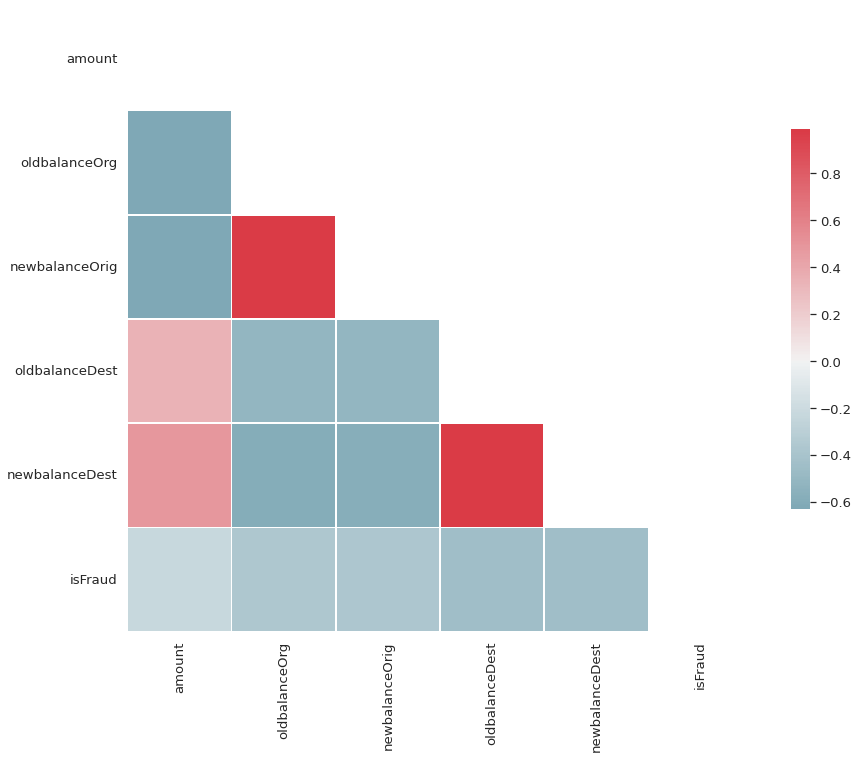

In [25]:
corr_matrix = df[num_vars + [target]].corr()
plot_corr_matrix(corr_matrix)